In [1]:
'''A jupyter notebook detailing the use of the
particle filter to fit a model with a synthetic data set with some missing values.'''

'A jupyter notebook detailing the use of the\nparticle filter to fit a model with a synthetic data set with some missing values.'

In [2]:
import numpy as np
from epymorph.forecasting.likelihood import Poisson,Gaussian,NegativeBinomial

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)

In [3]:
from epymorph.kit import *
from epymorph.adrio import acs5, us_tiger

my_rng = np.random.default_rng(1)

time_frame = TimeFrame.of("2015-01-01", 150)
scope = CountyScope.in_counties(["King, WA","Whatcom, WA","Pierce, WA","Snohomish, WA"], year=2015)

rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=scope,
    # Create a SingleLocation initializer
    init=init.SingleLocation(location=0, seed_size=100),
    # Set the time-frame to simulate
    time_frame=time_frame,
    # Provide model parameter values
    params={
        "beta": 0.3,
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "commuter_proportion":0.5,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

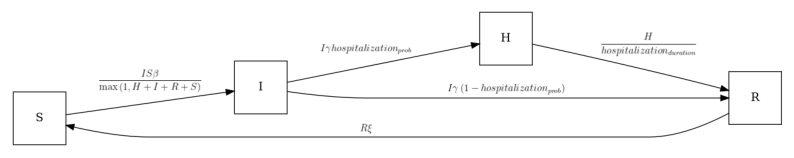

In [4]:
rume.ipm.diagram()

In [5]:

# Construct a simulator for the RUME
sim = BasicSimulator(rume)

# Run inside a sim_messaging context to display a nice progress bar
with sim_messaging():
    # Run and save the simulation Output object for later
    out = sim.run(
        # Use a seeded RNG (for the sake of keeping this notebook's results consistent)
        # This parameter is optional; by default a new RNG is constructed for each run
        # using numpy's default_rng
        rng_factory=default_rng(1)
    )

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.603s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-30 (150 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.167s


         date  geoid  value
43 2015-03-09  53073    NaN
3  2014-12-29  53073    NaN
64 2015-04-20  53033    NaN
82 2015-05-18  53061    NaN
39 2015-03-02  53073    NaN


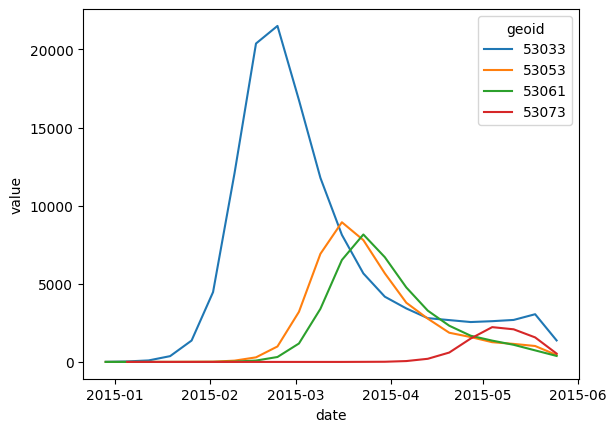

In [6]:
# Plot the compartment values in States throughout the simulation.
from epymorph.adrio import csv
from epymorph.tools.data import munge
import seaborn as sns
import pandas as pd


cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("week").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

'''Set some missing rows here'''
missing_rows = 5
missing_indices = my_rng.choice(cases_df.shape[0],replace = False,size = missing_rows)
cases_df.loc[missing_indices,"value"] = pd.NA
print(cases_df.loc[missing_indices])

sns.lineplot(data=cases_df,x='date',y='value',hue='geoid')

cases_df.to_csv('pf_vignettes/synthetic_data.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/synthetic_data.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)


In [7]:
from epymorph.forecasting.likelihood import NegativeBinomial

num_realizations = 100

pf_scope = CountyScope.in_counties(["King, WA","Whatcom, WA","Pierce, WA","Snohomish, WA"],year=2015)

pf_rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=pf_scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(1,1000),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Provide model parameter values
    params={
        "beta": 0.3,
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "hospitalization_prob":0.05,
        "commuter_proportion":0.5,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=pf_rume.scope.select.all(),
        time=pf_rume.time_frame.select.all().group("day").agg(),
        quantity=pf_rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)

particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(pf_rume,num_realizations),
        observations=my_observations,
        save_trajectories=True,
    )


In [9]:
particle_filter_output = particle_filter_simulator.run(rng=my_rng)

FloatingPointError: invalid value encountered in cast

In [ ]:
from epymorph.simulation import Context

context = Context.of(
    scope=pf_rume.scope,
    # We fetch data starting from the first fitting date to match the first nowcast.
    time_frame=pf_rume.time_frame,
    rng=my_rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

real_data_dates = real_data_result["date"][:, 0]

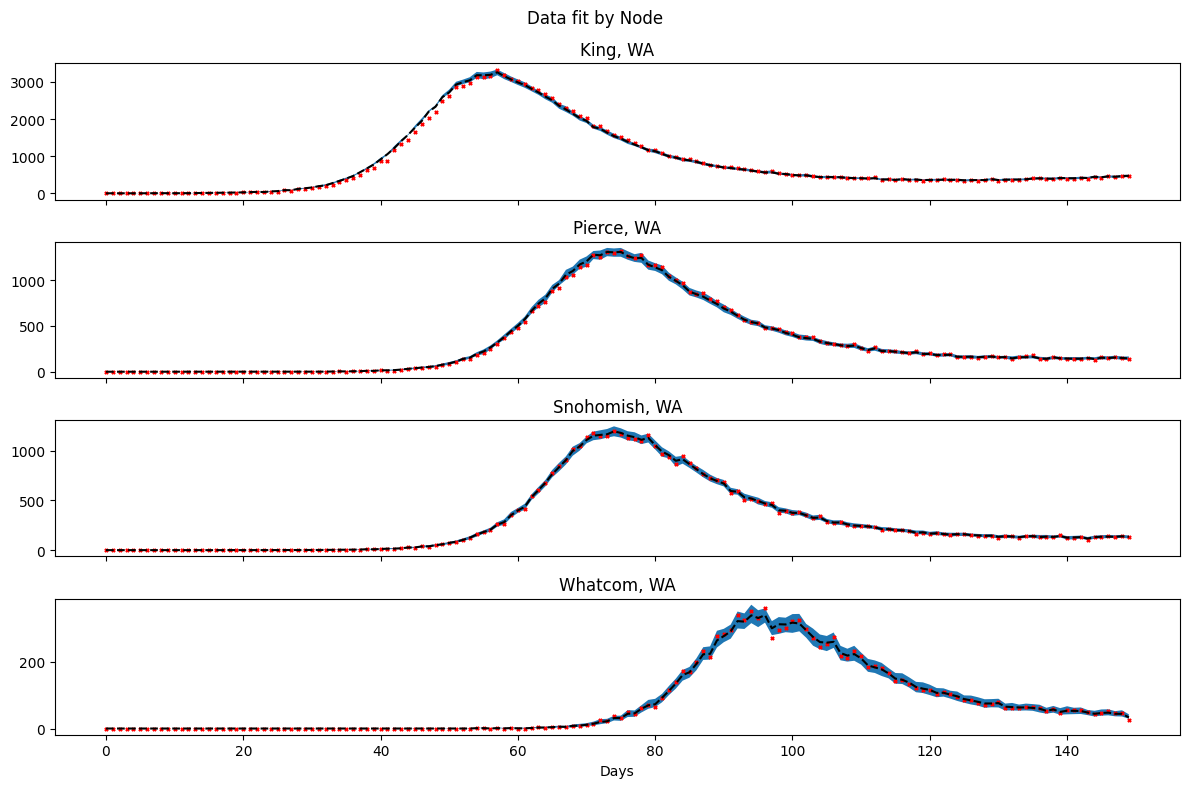

In [ ]:
import matplotlib.pyplot as plt

t_range = np.arange(pf_rume.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Data fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(particle_filter_output.posterior_values[:,:,node,:],97.5,axis = 1)[:,0]
        lower = np.percentile(particle_filter_output.posterior_values[:,:,node,:],2.5,axis = 1)[:,0]
        data_mean = np.mean((particle_filter_output.posterior_values[:,:,node,:]),axis = 1)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].plot(data_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_data[:,node],marker = 'x',color = 'red',s= 5)
ax[-1].set_xlabel('Days')
fig.tight_layout()
